# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only
The env enables the agent to freely bet on trading quantity.

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_RestrictFreeAmt_TradeEnv

folder_path = f"result/rl-restrict-thres-freeamt"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(10)

,time,close0,itvl,datetime,close1,spread,zscore
521369,1703818259999,0.000026,1m,2023-12-29 02:50:59.999,0.000028,-0.000002,-0.496491
521370,1703818319999,0.000026,1m,2023-12-29 02:51:59.999,0.000028,-0.000002,-0.475316
521371,1703818379999,0.000026,1m,2023-12-29 02:52:59.999,0.000028,-0.000002,-0.459767
521372,1703818439999,0.000026,1m,2023-12-29 02:53:59.999,0.000028,-0.000002,-0.353173
521373,1703818499999,0.000026,1m,2023-12-29 02:54:59.999,0.000028,-0.000002,-0.268318
521374,1703818559999,0.000026,1m,2023-12-29 02:55:59.999,0.000028,-0.000002,0.141809
521375,1703818619999,0.000026,1m,2023-12-29 02:56:59.999,0.000028,-0.000002,0.375112
521376,1703818679999,0.000026,1m,2023-12-29 02:57:59.999,0.000028,-0.000002,0.888931
521377,1703818739999,0.000026,1m,2023-12-29 02:58:59.999,0.000028,-0.000002,2.161925
521378,1703818799999,0.000026,1m,2023-12-29 02:59:59.999,0.000028,-0.000002,4.241137


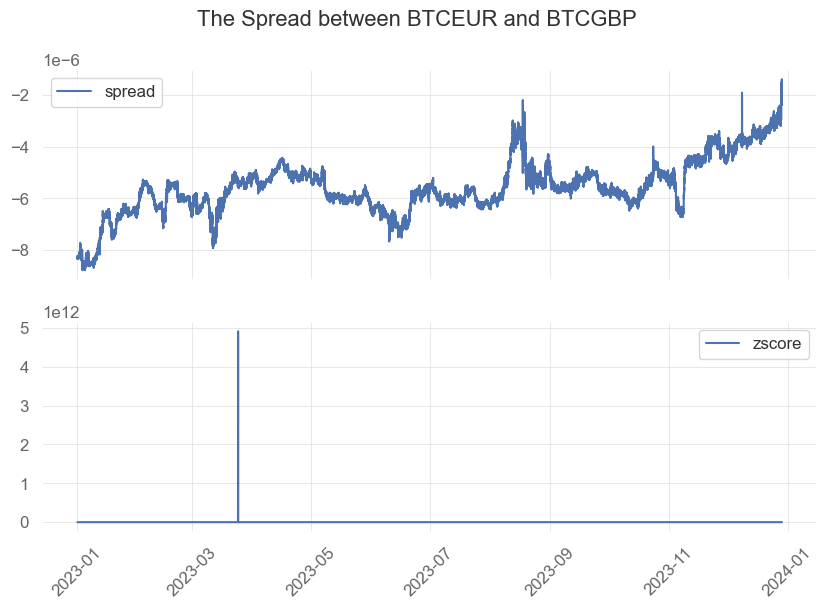

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period'])*0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 87840


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_RestrictFreeAmt_TradeEnv(train)
check_env(env)

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\stable_baselines3\common\env_checker.py:452: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


In [7]:
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(20):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    # test_env_expt.render()

test_env_expt.close()

100%|██████████| 20/20 [00:00<00:00, 147.55it/s]

Finished
networth: 0.9710006927330971


Tensorboard

## Train the Model with Trading Env

In [8]:
log_path = f"logs/restrict_thres_freeamt/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres_freeamt/A2C_1
Deleted: logs/restrict_thres_freeamt/PPO_1
Deleted: logs/restrict_thres_freeamt/SAC_1


In [9]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=False)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [10]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [11]:
# '''
# DDPG
# '''

# model_ddpg = DDPG("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
# model_ddpg.learn(total_timesteps=max_train_len*0.1, progress_bar=True)
# model_ddpg.save(f"{folder_path}/ddpg_pairtrading")

In [12]:
'''
SAC
'''

model_sac = SAC("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_sac.learn(total_timesteps=max_train_len, progress_bar=True)
model_sac.save(f"{folder_path}/sac_pairtrading")

Output()

In [13]:
# '''
# TD3
# '''

# model_td3 = TD3("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
# model_td3.learn(total_timesteps=max_train_len*0.8, progress_bar=True)
# model_td3.save(f"{folder_path}/td3_pairtrading")

## Create the Custom Test Env

In [14]:
test_env_ppo = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_ddpg = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ddpg.csv", verbose=1)
test_env_sac = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_sac.csv", verbose=1)
test_env_td3 = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_td3.csv", verbose=1)
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [15]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 38475


## Test Env with Trained Model

In [16]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 14/38475 [00:00<04:45, 134.57it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.70467657], dtype=float32)}, action: -1.0, reward:0.0, networth: 1.0


 10%|█         | 3869/38475 [00:44<05:17, 108.97it/s]

signal: {'holdings': array([-0.06205926,  0.06205926], dtype=float32), 'zone': 2, 'zscore': array([-0.44277287], dtype=float32)}, action: -0.146465003490448, reward:0.0, networth: 0.0303


 20%|██        | 7714/38475 [01:19<04:39, 109.99it/s]

signal: {'holdings': array([ 0.99572605, -0.99572605], dtype=float32), 'zone': 4, 'zscore': array([-1.7045445], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.0005


 30%|███       | 11553/38475 [01:53<03:51, 116.08it/s]

signal: {'holdings': array([ 0.9898216, -0.9898216], dtype=float32), 'zone': 0, 'zscore': array([0.99918795], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0


 40%|████      | 15402/38475 [02:27<03:29, 109.90it/s]

signal: {'holdings': array([ 0.9974883, -0.9974883], dtype=float32), 'zone': 4, 'zscore': array([-0.90556335], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.0


 50%|█████     | 19254/38475 [03:02<02:48, 114.36it/s]

signal: {'holdings': array([-0.9995772,  0.9995772], dtype=float32), 'zone': 2, 'zscore': array([0.04939379], dtype=float32)}, action: -0.29974302649497986, reward:0.0, networth: 0.0


 60%|██████    | 23105/38475 [03:36<02:24, 106.46it/s]

signal: {'holdings': array([-0.98945373,  0.98945373], dtype=float32), 'zone': 0, 'zscore': array([0.985942], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0


 70%|███████   | 26947/38475 [04:11<01:36, 119.47it/s]

signal: {'holdings': array([ 0.09091619, -0.09091619], dtype=float32), 'zone': 4, 'zscore': array([-0.81229407], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.0


 80%|████████  | 30795/38475 [04:46<01:07, 114.32it/s]

signal: {'holdings': array([ 1.0012561, -1.0012561], dtype=float32), 'zone': 2, 'zscore': array([-0.00030879], dtype=float32)}, action: 0.7345669269561768, reward:0.0, networth: 0.0


 90%|█████████ | 34642/38475 [05:20<00:34, 112.47it/s]

signal: {'holdings': array([ 0.9968508, -0.9968508], dtype=float32), 'zone': 4, 'zscore': array([-1.4572589], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.0


100%|██████████| 38475/38475 [05:55<00:00, 108.21it/s]

signal: {'holdings': array([ 0.99507326, -0.99507326], dtype=float32), 'zone': 4, 'zscore': array([-1.920254], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.0
Finished
networth: 9.357830265800643e-18


In [17]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

test_env_a2c = RL_RestrictFreeAmt_TradeEnv(test, tc=0.002, model=f"{folder_path}/networth_a2c.csv", verbose=1)
obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

# for i in trange(10):
#     action, _states = model_a2c.predict(obs)
#     obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
#     test_env_a2c.render()

# test_env_a2c.close()

  0%|          | 0/38475 [00:00<?, ?it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.70467657], dtype=float32)}, action: -1.0, reward:0.0, networth: 1.0


 10%|█         | 3863/38475 [00:45<04:38, 124.35it/s]

signal: {'holdings': array([ 0.99671334, -0.99671334], dtype=float32), 'zone': 2, 'zscore': array([-0.44277287], dtype=float32)}, action: 1.0, reward:0.0, networth: 0.6319


 20%|██        | 7712/38475 [01:16<03:59, 128.57it/s]

signal: {'holdings': array([ 0.9961285, -0.9961285], dtype=float32), 'zone': 4, 'zscore': array([-1.7045445], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.3973


 30%|███       | 11565/38475 [01:46<03:33, 125.92it/s]

signal: {'holdings': array([-0.99688876,  0.99688876], dtype=float32), 'zone': 0, 'zscore': array([0.99918795], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.2511


 40%|████      | 15406/38475 [02:17<03:05, 124.44it/s]

signal: {'holdings': array([ 0.99750745, -0.99750745], dtype=float32), 'zone': 4, 'zscore': array([-0.90556335], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.1504


 50%|█████     | 19263/38475 [02:47<02:28, 129.70it/s]

signal: {'holdings': array([-0.9947414,  0.9947414], dtype=float32), 'zone': 2, 'zscore': array([0.04939379], dtype=float32)}, action: -1.0, reward:0.0, networth: 0.0978


 60%|██████    | 23110/38475 [03:19<02:01, 126.07it/s]

signal: {'holdings': array([-0.99465185,  0.99465185], dtype=float32), 'zone': 0, 'zscore': array([0.985942], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0605


 70%|███████   | 26950/38475 [03:49<01:30, 126.74it/s]

signal: {'holdings': array([ 0.9964601, -0.9964601], dtype=float32), 'zone': 4, 'zscore': array([-0.81229407], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.0392


 80%|████████  | 30796/38475 [04:21<01:01, 124.97it/s]

signal: {'holdings': array([-0.99833965,  0.99833965], dtype=float32), 'zone': 2, 'zscore': array([-0.00030879], dtype=float32)}, action: -1.0, reward:0.0, networth: 0.0247


 90%|█████████ | 34638/38475 [04:51<00:29, 131.69it/s]

signal: {'holdings': array([ 0.9968499, -0.9968499], dtype=float32), 'zone': 4, 'zscore': array([-1.4572589], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.0168


100%|██████████| 38475/38475 [05:22<00:00, 119.18it/s]

signal: {'holdings': array([-0.99524987,  0.99524987], dtype=float32), 'zone': 4, 'zscore': array([-1.920254], dtype=float32)}, action: -1.0, reward:0.0, networth: 0.0124


In [18]:
# try:
#     os.remove(f"{folder_path}/networth_ddpg.csv")
# except OSError:
#     pass

# obs, _ = test_env_ddpg.reset()

# for i in trange(max_test_len):
#     action, _states = model_ddpg.predict(obs)
#     obs, rewards, terminated, truncated, info = test_env_ddpg.step(action)
#     if i%int(max_test_len/10)==0:
#         test_env_ddpg.render()

# test_env_ddpg.close()

In [19]:
try:
    os.remove(f"{folder_path}/networth_sac.csv")
except OSError:
    pass

obs, _ = test_env_sac.reset()

for i in trange(max_test_len):
    action, _states = model_sac.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_sac.step(action)
    if i%int(max_test_len/10)==0:
        test_env_sac.render()

test_env_sac.close()

  0%|          | 0/38475 [00:00<?, ?it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.70467657], dtype=float32)}, action: -0.5038594007492065, reward:0.0, networth: 1.0


 10%|█         | 3872/38475 [00:37<04:42, 122.49it/s]

signal: {'holdings': array([ 0.62874866, -0.62874866], dtype=float32), 'zone': 2, 'zscore': array([-0.44277287], dtype=float32)}, action: 0.6647903919219971, reward:0.0, networth: 0.0094


 20%|██        | 7714/38475 [01:09<04:06, 124.69it/s]

signal: {'holdings': array([ 0.8487081, -0.8487081], dtype=float32), 'zone': 4, 'zscore': array([-1.7045445], dtype=float32)}, action: 0.6937720775604248, reward:1.0, networth: 0.0


 30%|███       | 11555/38475 [01:40<03:32, 126.86it/s]

signal: {'holdings': array([ 0.875925, -0.875925], dtype=float32), 'zone': 0, 'zscore': array([0.99918795], dtype=float32)}, action: -0.7144956588745117, reward:1.0, networth: 0.0


 40%|████      | 15408/38475 [02:12<03:13, 119.33it/s]

signal: {'holdings': array([ 0.8430447, -0.8430447], dtype=float32), 'zone': 4, 'zscore': array([-0.90556335], dtype=float32)}, action: 0.7936873435974121, reward:1.0, networth: 0.0


 50%|█████     | 19258/38475 [02:43<02:31, 126.47it/s]

signal: {'holdings': array([-0.28528884,  0.28528884], dtype=float32), 'zone': 2, 'zscore': array([0.04939379], dtype=float32)}, action: 0.42561912536621094, reward:-0.0, networth: 0.0


 60%|██████    | 23097/38475 [03:15<02:20, 109.77it/s]

signal: {'holdings': array([-0.5764822,  0.5764822], dtype=float32), 'zone': 0, 'zscore': array([0.985942], dtype=float32)}, action: -0.2225172519683838, reward:1.0, networth: 0.0


 70%|███████   | 26943/38475 [03:46<01:30, 127.31it/s]

signal: {'holdings': array([-0.24854986,  0.24854986], dtype=float32), 'zone': 4, 'zscore': array([-0.81229407], dtype=float32)}, action: 0.3293198347091675, reward:1.0, networth: 0.0


 80%|████████  | 30792/38475 [04:18<01:01, 124.03it/s]

signal: {'holdings': array([ 0.38025627, -0.38025627], dtype=float32), 'zone': 2, 'zscore': array([-0.00030879], dtype=float32)}, action: -0.8138870000839233, reward:-0.0, networth: 0.0


 90%|█████████ | 34643/38475 [04:50<00:30, 123.86it/s]

signal: {'holdings': array([ 0.69724953, -0.69724953], dtype=float32), 'zone': 4, 'zscore': array([-1.4572589], dtype=float32)}, action: 0.9817425012588501, reward:1.0, networth: 0.0


100%|██████████| 38475/38475 [05:21<00:00, 119.52it/s]

signal: {'holdings': array([ 0.599103, -0.599103], dtype=float32), 'zone': 4, 'zscore': array([-1.920254], dtype=float32)}, action: 0.9674010276794434, reward:1.0, networth: 0.0
Finished
networth: 7.680663674018804e-23


In [20]:
# try:
#     os.remove(f"{folder_path}/networth_td3.csv")
# except OSError:
#     pass

# obs, _ = test_env_td3.reset()

# for i in trange(max_test_len):
#     action, _states = model_td3.predict(obs)
#     obs, rewards, terminated, truncated, info = test_env_td3.step(action)
#     if i%int(max_test_len/10)==0:
#         test_env_td3.render()

# test_env_td3.close()

## Also run randomly generated actions

In [21]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

  0%|          | 0/38475 [00:00<?, ?it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.70467657], dtype=float32)}, action: -0.09887535618323007, reward:0.0, networth: 1.0


 10%|█         | 3868/38475 [00:34<03:31, 163.74it/s]

signal: {'holdings': array([ 0.63025093, -0.63025093], dtype=float32), 'zone': 2, 'zscore': array([-0.44277287], dtype=float32)}, action: -0.7257270565948148, reward:-0.0, networth: 0.0017


 20%|██        | 7719/38475 [00:58<03:17, 156.05it/s]

signal: {'holdings': array([ 0.5188417, -0.5188417], dtype=float32), 'zone': 4, 'zscore': array([-1.7045445], dtype=float32)}, action: -0.8478929043177998, reward:-0.0, networth: 0.0


 30%|███       | 11568/38475 [01:22<02:41, 166.59it/s]

signal: {'holdings': array([-0.3818472,  0.3818472], dtype=float32), 'zone': 0, 'zscore': array([0.99918795], dtype=float32)}, action: 0.894794220622396, reward:-0.0, networth: 0.0


 40%|████      | 15417/38475 [01:46<02:18, 166.63it/s]

signal: {'holdings': array([-0.3081934,  0.3081934], dtype=float32), 'zone': 4, 'zscore': array([-0.90556335], dtype=float32)}, action: 0.5550807877757444, reward:1.0, networth: 0.0


 50%|█████     | 19254/38475 [02:10<01:55, 166.51it/s]

signal: {'holdings': array([-0.7561836,  0.7561836], dtype=float32), 'zone': 2, 'zscore': array([0.04939379], dtype=float32)}, action: 0.35941152143530464, reward:-0.0, networth: 0.0


 60%|██████    | 23109/38475 [02:33<01:32, 166.82it/s]

signal: {'holdings': array([ 0.77423245, -0.77423245], dtype=float32), 'zone': 0, 'zscore': array([0.985942], dtype=float32)}, action: -0.050037766956191554, reward:1.0, networth: 0.0


 70%|███████   | 26961/38475 [02:57<01:10, 162.41it/s]

signal: {'holdings': array([ 0.13850993, -0.13850993], dtype=float32), 'zone': 4, 'zscore': array([-0.81229407], dtype=float32)}, action: -0.17584289799324893, reward:-0.0, networth: 0.0


 80%|████████  | 30807/38475 [03:22<00:49, 156.14it/s]

signal: {'holdings': array([-0.09526453,  0.09526453], dtype=float32), 'zone': 2, 'zscore': array([-0.00030879], dtype=float32)}, action: -0.22565143135532462, reward:0.0, networth: 0.0


 90%|█████████ | 34657/38475 [03:46<00:23, 165.16it/s]

signal: {'holdings': array([-0.812634,  0.812634], dtype=float32), 'zone': 4, 'zscore': array([-1.4572589], dtype=float32)}, action: 0.47161045417325886, reward:1.0, networth: 0.0


100%|██████████| 38475/38475 [04:10<00:00, 153.55it/s]

signal: {'holdings': array([ 0.89215064, -0.89215064], dtype=float32), 'zone': 4, 'zscore': array([-1.920254], dtype=float32)}, action: 0.2760729540461957, reward:1.0, networth: 0.0
Finished
networth: 1.024815985159326e-28


### Analyze with Quanstats

In [22]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-12-27 17:35:59.999000', '0.012367952559964293']
The ending capital of networth_ppo.csv is ['2023-12-27 17:35:59.999000', '9.357830265800643e-18']
The ending capital of networth_sac.csv is ['2023-12-27 17:35:59.999000', '7.680663674018804e-23']
The best model is networth_a2c.csv


In [23]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: -100%
Total orders count: 38474
Total long action: 0
Total short action: 0
Won orders count: 37
Lost orders count: 1328
Win/Loss order ratio: 0.02786144578313253
Max win: 0.0015520804197065585
Max Loss: -0.007544413852203502
Avg order pnl: -2.5670116115819406e-05
Avg order pnl won: 0.00022197215036556467
Avg order pnl lost: -0.0007498832959364169


In [24]:
best_return

,values,action,zscore,position,price0,price1,pnl,returns
datetime,,,,,,,,
2023-12-01 00:22:59.999,1.000000,-1.000000,0.795478,[-0.9958078 0.9958078],0.000029,0.000033,0.000000,0.000000
2023-12-01 00:23:59.999,1.000000,-1.000000,0.351193,[-0.99586964 0.99586964],0.000029,0.000033,0.000000,0.000000
2023-12-01 00:24:59.999,1.000000,-1.000000,0.317285,[-0.99615514 0.99615514],0.000029,0.000033,0.000000,0.000000
2023-12-01 00:25:59.999,1.000000,-1.000000,0.334751,[-0.9959945 0.9959945],0.000029,0.000033,0.000000,0.000000
2023-12-01 00:26:59.999,1.000000,-1.000000,1.954162,[-0.99662995 0.99662995],0.000029,0.000033,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-12-27 17:31:59.999,0.012410,-1.000000,-1.676912,[-0.99646336 0.99646336],0.000026,0.000028,0.000000,0.000000
2023-12-27 17:32:59.999,0.012410,-1.000000,-1.556469,[-0.99568665 0.99568665],0.000026,0.000028,0.000000,0.000000
2023-12-27 17:33:59.999,0.012410,-1.000000,-1.942521,[-0.995495 0.995495],0.000026,0.000028,0.000000,0.000000


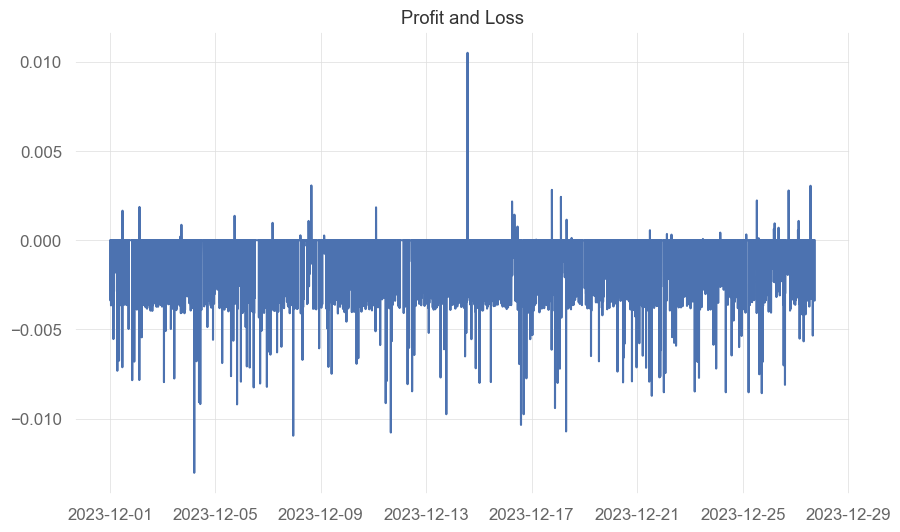

In [25]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-12-01
End Period                 2023-12-27
Risk-Free Rate             0.0%
Time in Market             4.0%

Cumulative Return          -98.76%
CAGR﹪                     -100.0%

Sharpe                     -2.69
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -2.65
Sortino                    -2.66
Smart Sortino              -2.62
Sortino/√2                 -1.88
Smart Sortino/√2           -1.85
Omega                      0.01

Max Drawdown               -98.76%
Longest DD Days            27
Volatility (ann.)          1.07%
Calmar                     -1.01
Skew                       -6.73
Kurtosis                   59.38

Expected Daily %           -0.01%
Expected Monthly %         -98.76%
Expected Yearly %          -98.76%
Kelly Criterion            -238.16%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.12%
Expected Shortfall (cVaR)  -0.12%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-12-01,2023-12-27,2023-12-27,27,-98.763205,-98.721386


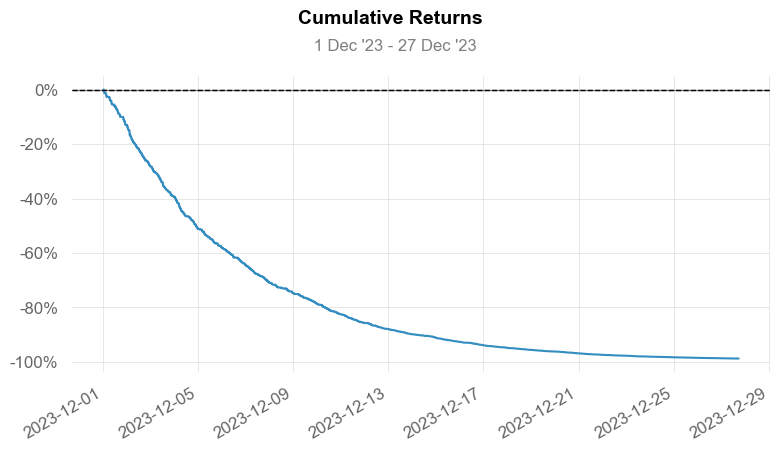

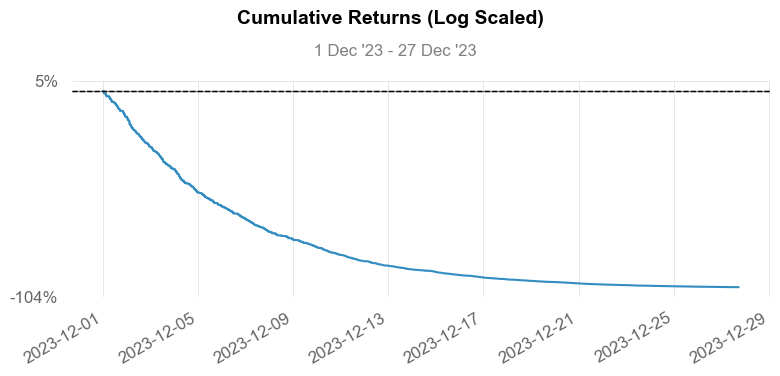

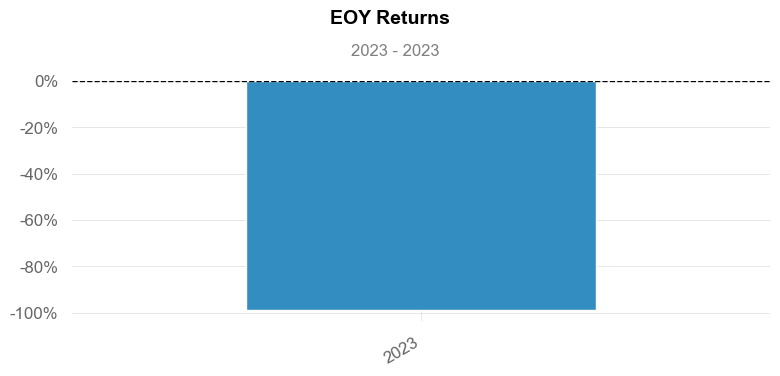

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


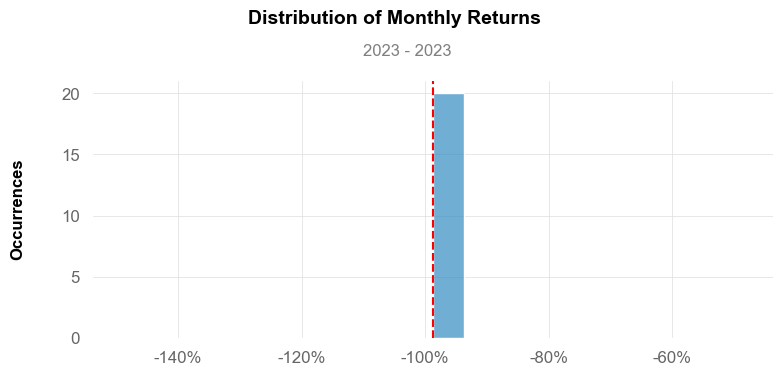

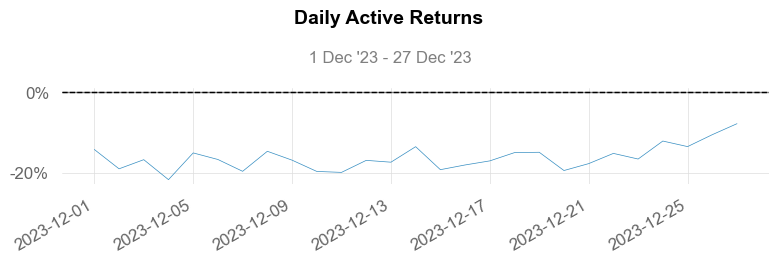

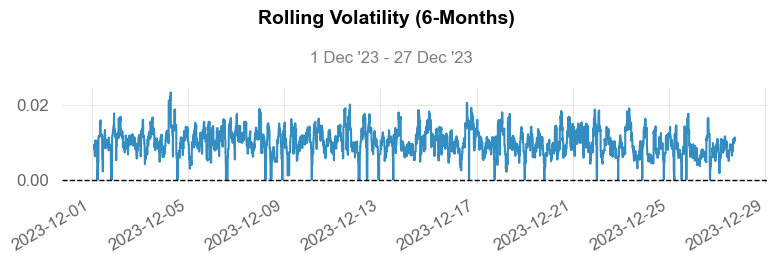

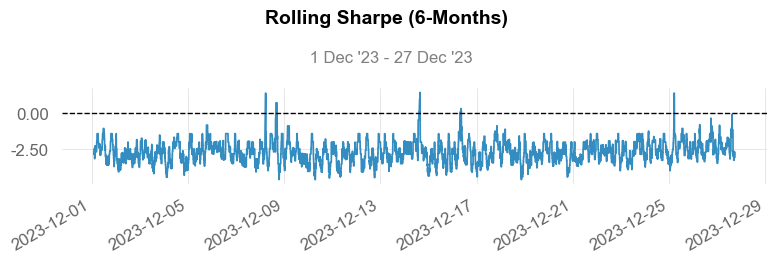

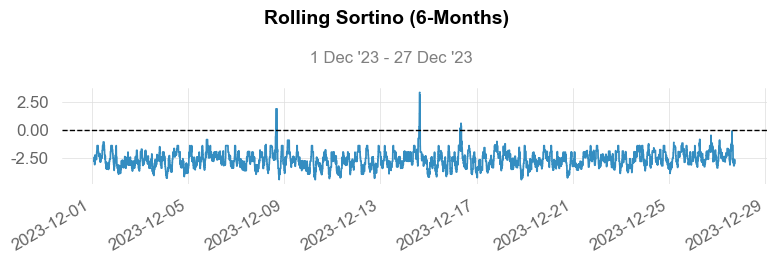

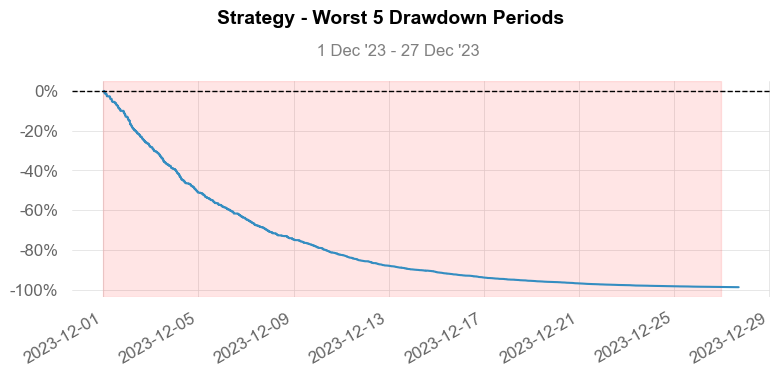

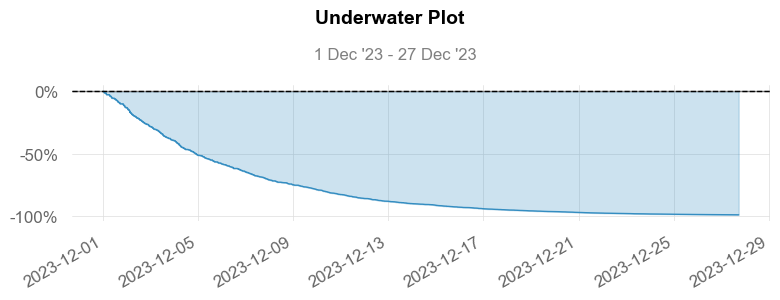

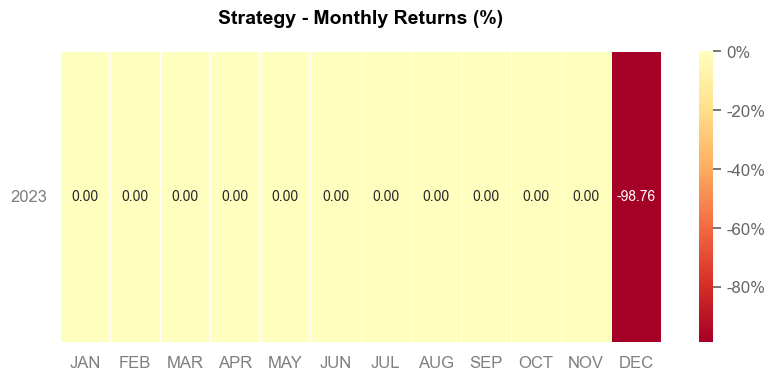

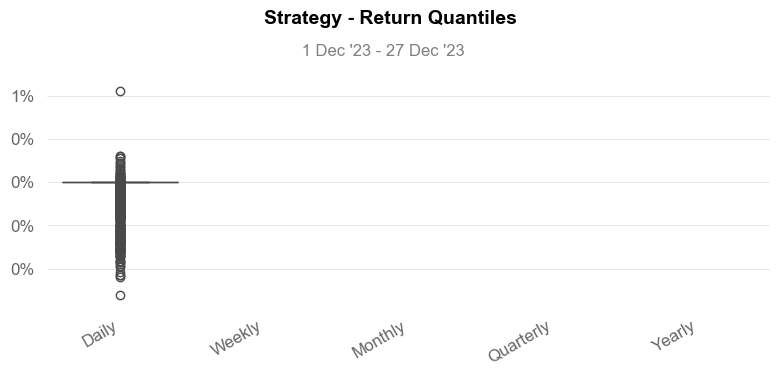

In [26]:
qs.reports.full(best_return['returns'])